# Smartwatch Activity Recognition using TSFEL

On this example we will perform Human Activty Recognition using our library **Time Series Feature Extraction Library**.

To perform this example every cell must be executed. To do so click run ([  ]) in the top left of every cell.

The first step consists on importing the library. To do that press play.

The import can take a few seconds, but the run button will change so that you know the import has started and ended.

A warning will appear to reset all runtimes before running, click to accept.

In [1]:
#@title Import Time Series Feature Extraction Library
import warnings
warnings.filterwarnings('ignore')
!pip install tsfel >/dev/null 2>&1
from sys import platform
if platform == "linux" or platform == "linux2":
    !wget http://archive.ics.uci.edu/ml/machine-learning-databases/00507/wisdm-dataset.zip >/dev/null 2>&1
else:
    !pip install wget >/dev/null 2>&1
    import wget
    wget.download('http://archive.ics.uci.edu/ml/machine-learning-databases/00507/wisdm-dataset.zip')

Le chemin d'acc�s sp�cifi� est introuvable.
Le chemin d'acc�s sp�cifi� est introuvable.


KeyboardInterrupt: 

# Imports

To check if everything was correctly imported, access "Files" (on the left side of the screen) and press "Refresh". If UCI HAR Dataset folder does not appear run Import Time Series Features library again.

In [ ]:
# Import libraries
import glob
import tsfel
import secrets
import zipfile
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import interpolate
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

# Unzip dataset
zip_ref = zipfile.ZipFile("wisdm-dataset.zip", 'r')
zip_ref.extractall()
zip_ref.close()

# Auxiliary Methods

**Data pre-processing**

Method to interpolate accelerometer and gyroscope data to the same time interval.

In [ ]:
def pre_process_data(data_acc, data_gyro, fs):
    """This function interpolates the accelerometer and gyroscope data to
    the same time interval.

    Parameters
    ----------
    data_acc nd-array
    Accelerometer data of specified activity
    data_gyro nd-array
    Gyroscope data of specified activity
    fs int
    Sampling frequency

    Returns
    -------
    Interpolated data (nd-array)

    """
    time_acc = (data_acc[:, 2])/1e9 - data_acc[0, 2]/1e9
    data_act_acc = data_acc[:, 3:]

    time_gyro = (data_gyro[:, 2])/1e9 - data_gyro[0, 2]/1e9
    data_act_gyro = data_gyro[:, 3:]

    # time interval for interpolation
    t0 = np.max([time_acc[0], time_gyro[0]])
    tn = np.min([time_acc[-1], time_gyro[-1]])
    time_new = np.linspace(t0, tn, int((tn - t0) / ((1 / fs))))

    # interpolation
    acc_data = np.array([interpolate.interp1d(time_acc, data_act_acc[:, ax])(time_new) for ax in range(np.shape(data_act_acc)[1])]).T
    gyro_data = np.array([interpolate.interp1d(time_gyro, data_act_gyro[:, ax])(time_new) for ax in range(np.shape(data_act_gyro)[1])]).T

    # concatenate interpolated data
    data = np.concatenate((acc_data, gyro_data), axis = 1)

    return data

# Dataset

The dataset we will be using is open-source. It is provided by UCI and it was performed by 51 subjects using a smartphone on their pocket and a smartwatch on their dominant hand. It contains a total of 18 activities whose labels are given by the following letters:

* Walking = A
* Jogging = B
* Stairs = C
* Sitting = D
* Standing = E
* Typing = F
* Brushing Teeth = G
* Eating Soup = H
* Eating Chips = I
* Eating Pasta = J
* Drinking from Cup = K
* Eating Sandwich = L
* Kicking Soccer Ball = M
* Playing Catch w/Tennis Ball = O
* Dribblinlg Basketball = P
* Writing = Q
* Clapping = R
* Folding Clothes = S

For this classification problem only the smartwatch data will be used.

The dataset used in this example can be found [here](https://archive.ics.uci.edu/ml/datasets/WISDM+Smartphone+and+Smartwatch+Activity+and+Biometrics+Dataset+).

# Load Data

Files from accelerometer and gyroscope of the smartwatch will be loaded.


In [ ]:
# Loading smartwatch data files
watch_files_acc = np.sort(glob.glob('wisdm-dataset/raw/watch/accel' + "*/**.txt", recursive=True))
watch_files_gyro = np.sort(glob.glob('wisdm-dataset/raw/watch/gyro' + "*/**.txt", recursive=True))

# Defining train and test

Data will be splitted into equal sized windows according to the performed activity.

Train and Test sets will be defined.

In [ ]:
all_acc_data = [np.array(pd.read_csv(acc_file, header = None, delimiter = ',', comment=';')) for acc_file in watch_files_acc]
all_gyro_data = [np.array(pd.read_csv(gyro_file, header = None, delimiter = ',', comment=';')) for gyro_file in watch_files_gyro]

x_test = []
x_train = []
y_test = []
y_train = []
activities = np.unique(np.vstack(all_acc_data)[:,1]).astype(str)
ntrain = 45
fs = 20 # According to dataset information
overlap = 0
ws = 200 # 10 second windows

for acq, (acc_data, gyro_data) in enumerate(zip(all_acc_data, all_gyro_data)):

    windows = []
    labels = []

    for act in activities:
        act_acc, act_gyro = np.where(acc_data == act)[0], np.where(gyro_data == act)[0]
        acc_data_act, gyro_data_act = acc_data[act_acc, :], gyro_data[act_gyro, :]
        ids_act_acc = np.append(0, np.where(np.diff(act_acc)>1)[0]+1)
        ids_act_gyro = np.append(0, np.where(np.diff(act_gyro)>1)[0]+1)

        if len(act_acc) == 0 or len(act_gyro) == 0:
            continue

        # Only one acquisition of act
        if (len(ids_act_gyro) == 1) and (len(ids_act_acc) == 1):
            data = pre_process_data(acc_data_act, gyro_data_act, fs)
            w = tsfel.signal_window_splitter(data.astype(float), ws, overlap)
            windows.append(w)
            labels.append(np.repeat(act, len(w)))
        else:
            # More than one acquisition of act
            acc_data_acts = [acc_data_act[ids_act_acc[i]:ids_act_acc[i+1], :] for i in range(len(ids_act_acc)-1)]
            gyro_data_acts = [gyro_data_act[ids_act_gyro[i]:ids_act_gyro[i+1], :] for i in range(len(ids_act_gyro)-1)]

            for acc_data_act, gyro_data_act in zip(acc_data_acts, gyro_data_acts):
                data = pre_process_data(acc_data_act, gyro_data_act, fs)
                w = tsfel.signal_window_splitter(data.astype(float), ws, overlap)
                windows.append(w)
                labels.append(np.repeat(act, len(w)))

    # Consider ntrain acquisitions for train and the remaining for test
    if acq<=ntrain:
        x_train.append(windows)
        y_train.append(np.hstack(labels))
    else:
        x_test.append(windows)
        y_test.append(np.hstack(labels))


KeyboardInterrupt: 

In [ ]:
all_acc_data = [np.array(pd.read_csv(acc_file, header = None, delimiter = ',', comment=';')) for acc_file in watch_files_acc]
all_acc_data[0]

array([[1600, 'A', 90426708196641, 7.091625, -0.5916671, 8.195502],
       [1600, 'A', 90426757696641, 4.972757, -0.15831658, 6.6967316],
       [1600, 'A', 90426807196641, 3.25372, -0.19183542, 6.107758],
       ...,
       [1600, 'S', 82724432737292, 8.126968, -8.143727, -5.076755],
       [1600, 'S', 82724482667332, 7.542783, -8.88593, -3.6306572],
       [1600, 'S', 82724532597372, 8.596231, -5.6178446, -3.6976948]],
      dtype=object)

In [ ]:
y_train = np.hstack(y_train)
y_test = np.hstack(y_test)
x_train = list(itertools.chain(*list(itertools.chain(*x_train))))
x_test = list(itertools.chain(*list(itertools.chain(*x_test))))

In [ ]:
np.shape(x_train)

(13890, 200, 6)

In [ ]:
y_train

array(['A', 'A', 'A', ..., 'S', 'S', 'S'], dtype='<U1')

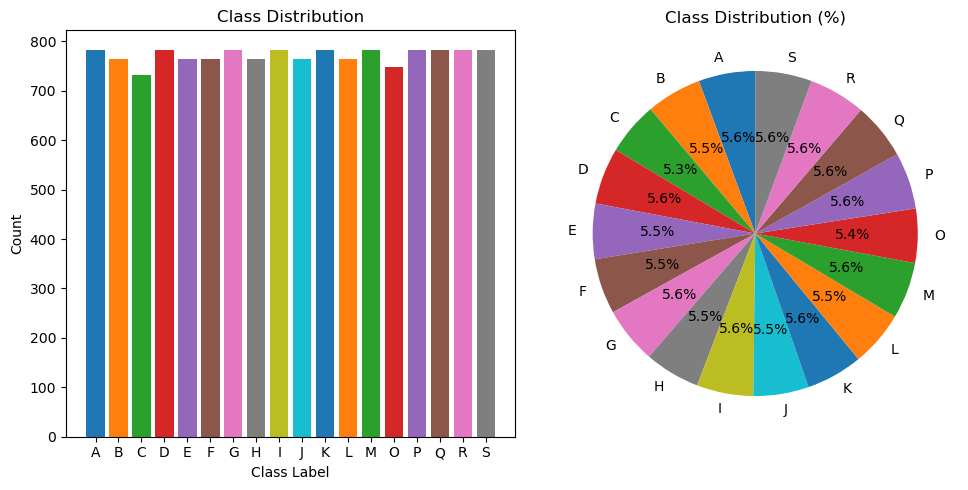

In [ ]:
unique_classes, counts = np.unique(y_train, return_counts=True)

# Set up subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Bar plot on the left
axs[0].bar(unique_classes, counts, color=plt.cm.tab10.colors)
axs[0].set_xlabel('Class Label')
axs[0].set_ylabel('Count')
axs[0].set_title('Class Distribution')

# Pie chart (rounded plot) on the right
axs[1].pie(counts, labels=unique_classes, autopct='%1.1f%%', colors=plt.cm.tab10.colors, startangle=90)
axs[1].set_title('Class Distribution (%)')

plt.tight_layout()
plt.show()

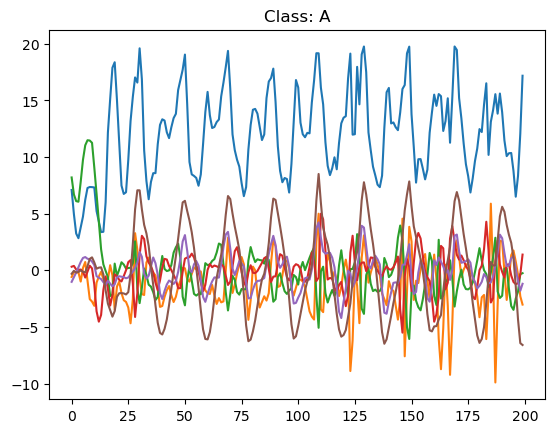

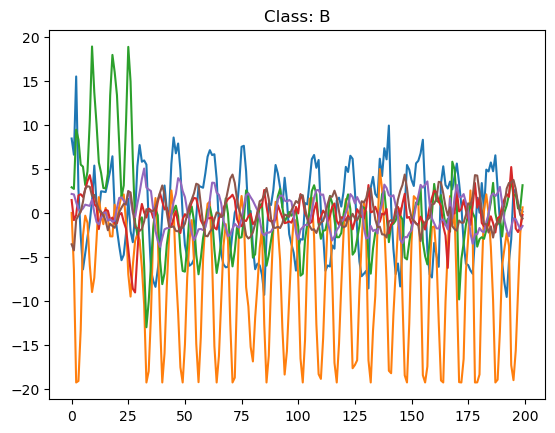

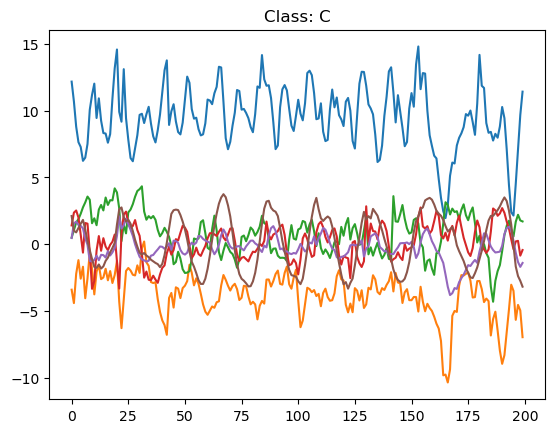

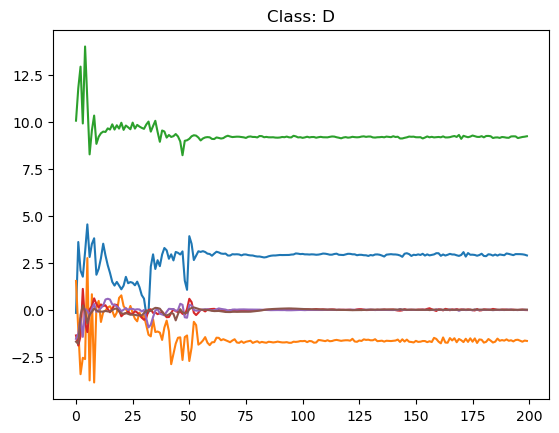

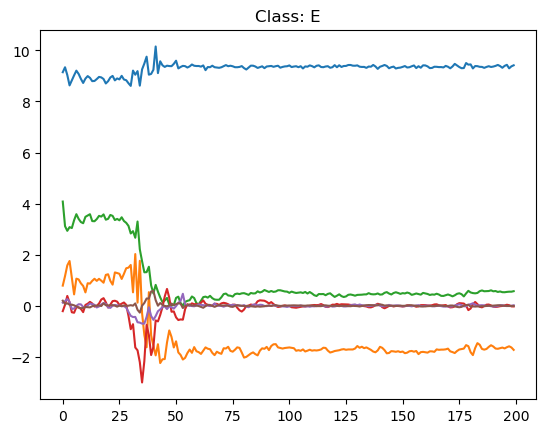

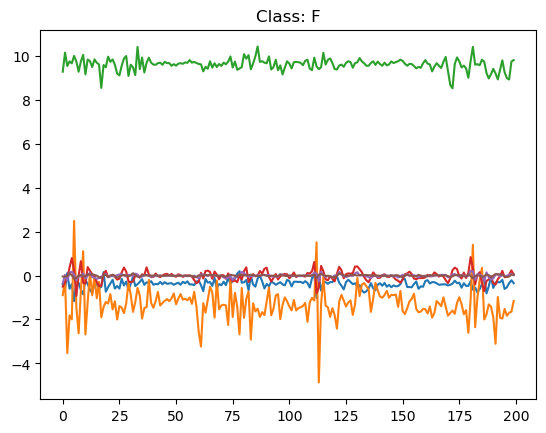

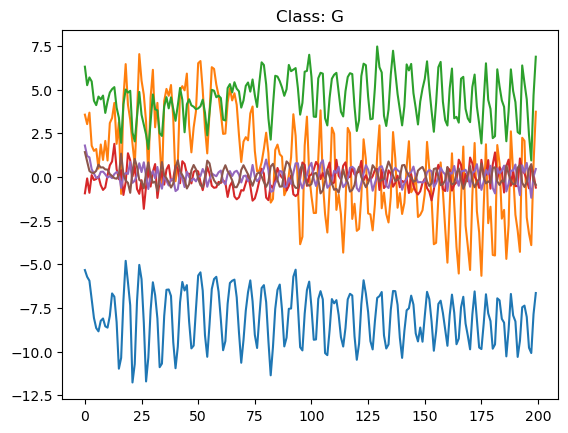

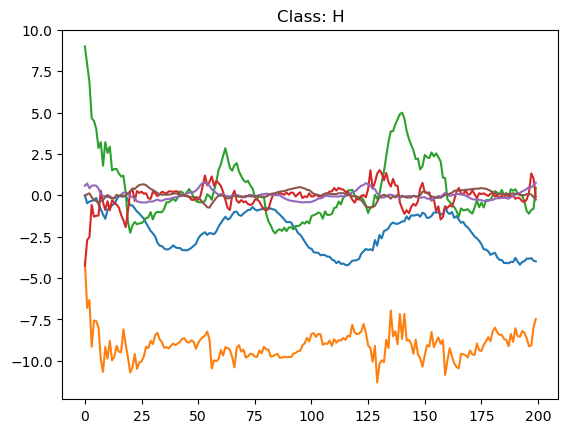

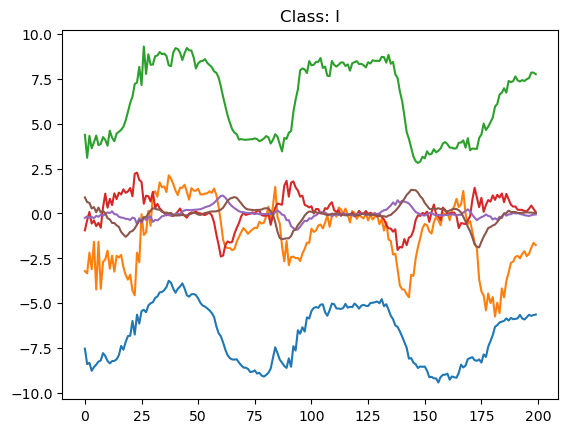

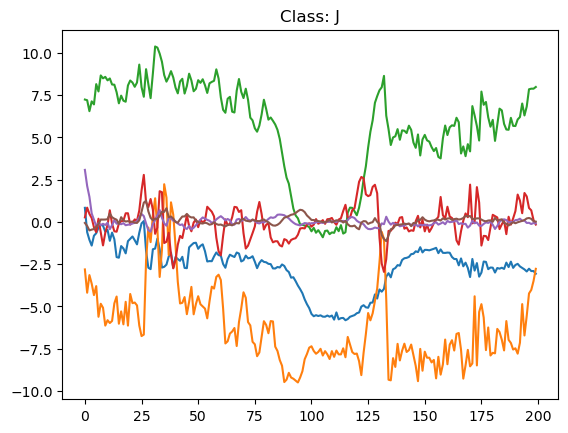

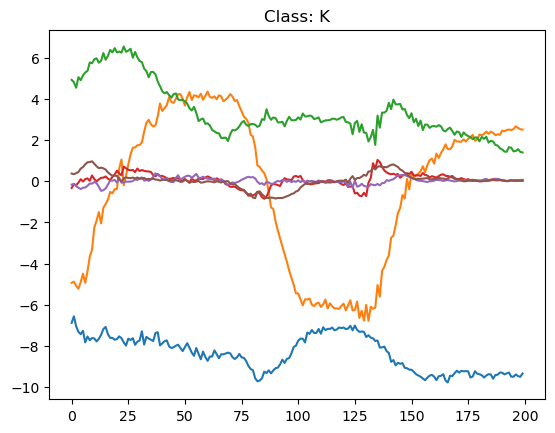

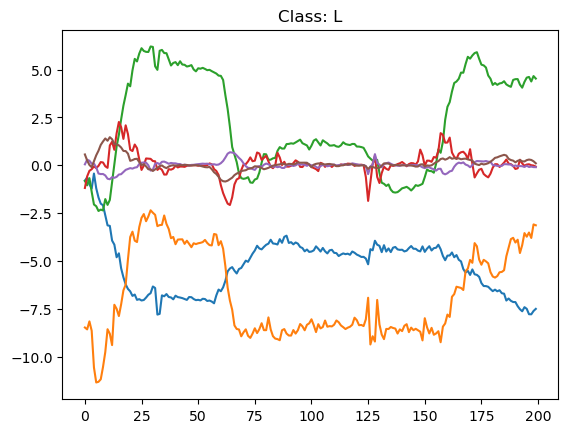

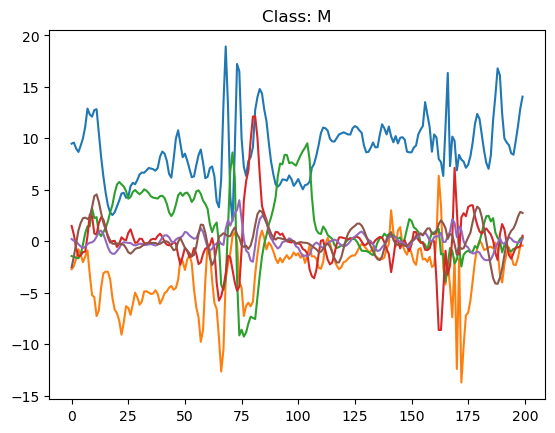

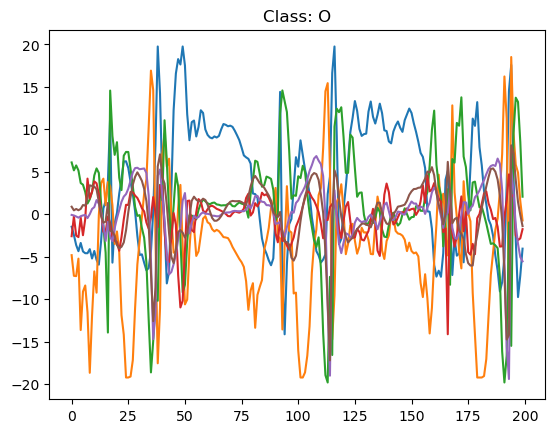

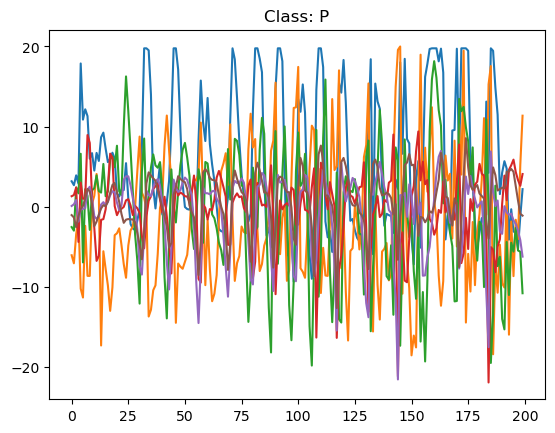

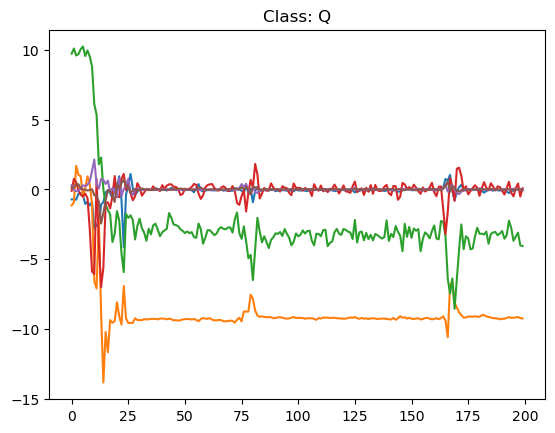

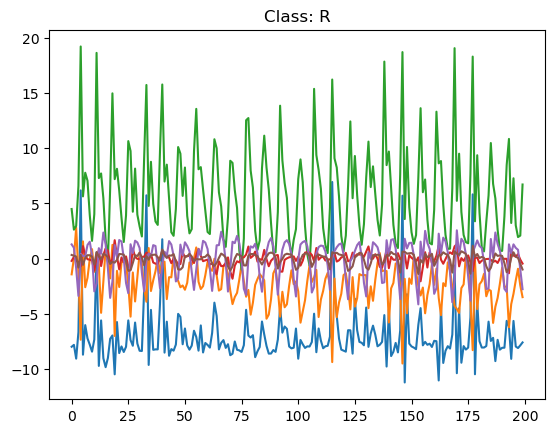

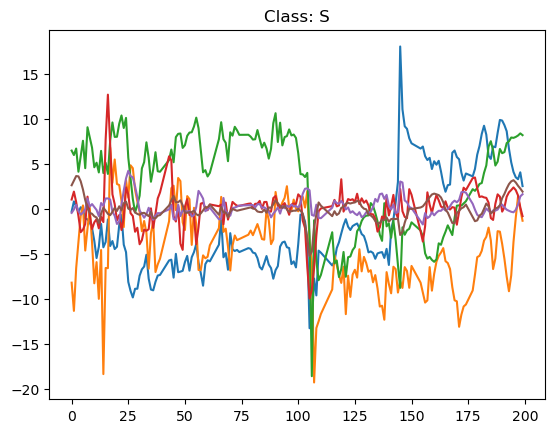

In [ ]:

# Loop over all classes
for class_label in np.unique(y_train):
    idx = np.where(y_train == class_label)[0]
    example_idx = idx[0]  # Choosing the first example for simplicity, you can modify this as needed
    
    # Plot the time series for the selected class and example
    plt.figure()
    plt.plot(x_train[example_idx])
    plt.title(f'Class: {class_label}')
    plt.show()

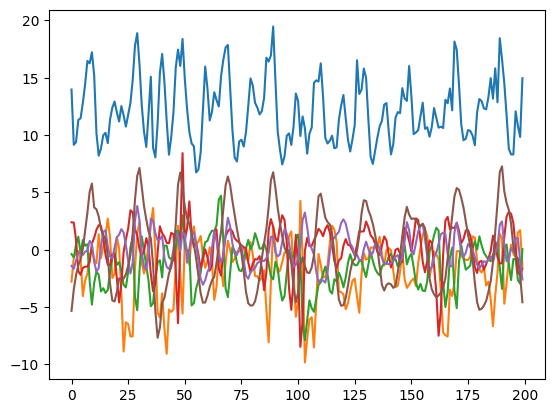

In [ ]:
plt.plot(x_train[1])

In [ ]:
np.shape(x_train)

(13890, 200, 6)

In [ ]:
len(x_train)

13890

# Feature Extraction

Through **Feature Extraction** methodologies, the data is translated into a feature vecture containing information about the signal properties of each window. These properties can be classifier according to their domain as Time, Frequency and Statistical features and allow to characterise the signal in a compact way, enhancing its chracteristics.

In this classification problem only features from the temporal domain will be used as input to the machine learning classifier.


In [ ]:
cfg_file = tsfel.get_features_by_domain('temporal')
x_train_feat = tsfel.time_series_features_extractor(cfg_file, x_train, fs = fs, header_names = ['accx', 'accy', 'accz', 'gyrox', 'gyroy', 'gyroz'])
x_test_feat = tsfel.time_series_features_extractor(cfg_file, x_test, fs = fs, header_names = ['accx', 'accy', 'accz', 'gyrox', 'gyroy', 'gyroz'])

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


# Feature Selection

After the sensor data is extracted, redundancies and noise should be removed. Thus, minimising the algorithm's error, time and computational complexity.

In [ ]:
# Highly correlated features are removed
corr_features = tsfel.correlated_features(x_train_feat)
x_train_feat.drop(corr_features, axis=1, inplace=True)
x_test_feat.drop(corr_features, axis=1, inplace=True)

# Remove low variance features
selector = VarianceThreshold()
X_train = selector.fit_transform(x_train_feat)
X_test = selector.transform(x_test_feat)

# Normalising Features
scaler = preprocessing.StandardScaler()
nX_train = scaler.fit_transform(X_train)
nX_test = scaler.transform(X_test)

# Classification

In this example the classification is performed with a [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) classifier.

In [ ]:
classifier = RandomForestClassifier(n_estimators = 20, min_samples_split=10)

activities = ['walking', 'jogging', 'stairs', 'sitting', 'standing', 'typing',
              'brushing teeth', 'eating soup', 'eating chips', 'eating pasta',
              'drinking', 'eating sandwich', 'kicking', 'playing catch',
              'dribblinlg', 'writing', 'clapping', 'folding clothes']

# Train The Classifier
classifier.fit(nX_train, y_train.ravel())

# Predict Test Data
y_predict = classifier.predict(nX_test)

# Get the Classification Report
accuracy = accuracy_score(y_test, y_predict)*100
print(classification_report(y_test, y_predict, target_names = activities))
print('Accuracy: ' + str(accuracy) + '%')

                 precision    recall  f1-score   support

        walking       0.76      0.60      0.67        85
        jogging       1.00      0.95      0.98        85
         stairs       0.74      0.67      0.70        85
        sitting       0.58      0.51      0.54        85
       standing       0.65      0.80      0.72        85
         typing       0.78      0.98      0.86        85
 brushing teeth       0.86      0.88      0.87        85
    eating soup       0.62      0.47      0.53        85
   eating chips       0.37      0.45      0.41        85
   eating pasta       0.73      0.71      0.72        85
       drinking       0.52      0.55      0.54        85
eating sandwich       0.35      0.27      0.31        85
        kicking       0.73      0.67      0.70       103
  playing catch       0.64      0.92      0.75        85
     dribblinlg       0.97      0.71      0.82        85
        writing       0.99      0.94      0.96        85
       clapping       0.90    

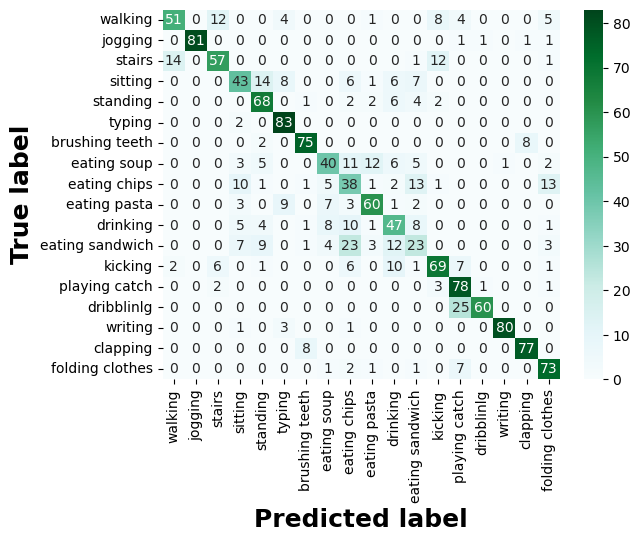

In [ ]:
import seaborn as sns
cm = confusion_matrix(y_test, y_predict)
df_cm = pd.DataFrame(cm, index=[i for i in activities], columns = [i for i in activities])
plt.figure()
ax = sns.heatmap(df_cm, cbar = True, cmap="BuGn", annot = True, fmt = 'd')
plt.setp(ax.get_xticklabels(), rotation = 90)
plt.ylabel('True label', fontweight = 'bold', fontsize = 18)
plt.xlabel('Predicted label', fontweight = 'bold', fontsize = 18)
plt.show()

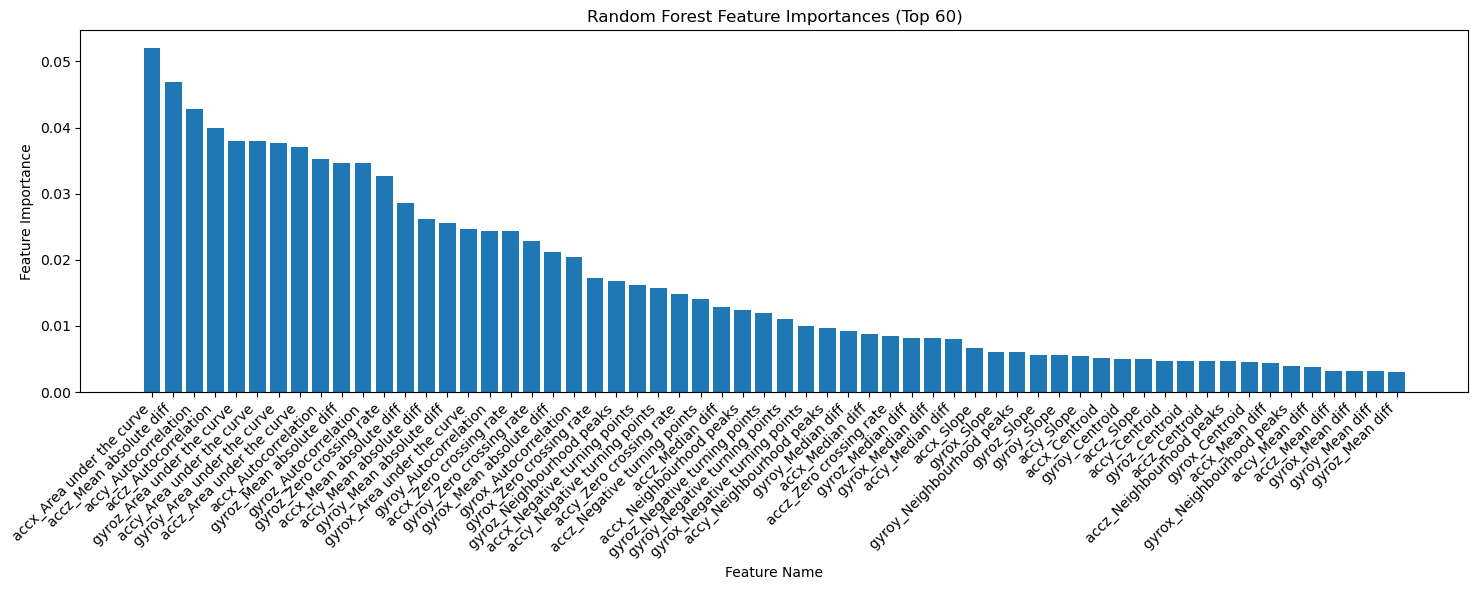

In [ ]:


feature_names = x_test_features.columns.tolist()
feature_importances = classifier.feature_importances_

# Sort indices based on feature importance
indices = np.argsort(feature_importances)[::-1]

# Plotting the feature importances with feature names
# Plotting the feature importances for the first 60 features
plt.figure(figsize=(15, 6))
plt.bar(range(60), feature_importances[indices][:60], align="center")
plt.xticks(range(60), [feature_names[i] for i in indices][:60], rotation=45, ha="right")
plt.xlabel("Feature Name")
plt.ylabel("Feature Importance")
plt.title("Random Forest Feature Importances (Top 60)")
plt.tight_layout()
plt.show()

# New features

In [1]:
from tsfel.utils.add_personal_features import add_feature_json

add_feature_json(r"C:\\Users\\TRETEC\\Documents\\MVA\\S1\\[AST]\\TSFEL_Review\\custom_code\\custom_feature.py",r"C:\\Users\\TRETEC\\Documents\\MVA\\S1\\[AST]\\TSFEL_Review\\custom_code\\features.json")

done
Feature permutation_entropy was added.
done
Feature approximate_entropy was added.


TypeError: unsupported callable

In [ ]:
#Custom feature : is_it_weekend
import tsfel
cfg_custom = tsfel.get_features_by_domain(json_path='custom_code/features.json')
cfg_custom
tsfel.time_series_features_extractor(cfg_custom, x_train, fs = fs, header_names = ['accx', 'accy', 'accz', 'gyrox', 'gyroy', 'gyroz'], features_path='C:\\Users\\TRETEC\\Documents\\MVA\\S1\\[AST]\\TSFEL_Review\\custom_code\\custom_feature.py')

NameError: name 'x_train' is not defined

In [ ]:
from functions import *

In [ ]:
import time

def calculate_entropy_features(x_train, x_train_feat):
    """
    Calculate entropy-related features for each component in each time series.

    Parameters:
    - x_train: List of arrays representing time series data.

    Returns:
    - result_df: DataFrame containing calculated features.
    """

    # Initialize an empty list to store the results
    df = []

    # Initialize variables to store overall execution time and feature-wise execution times
    overall_start_time = time.time()
    feature_times = {"PermEnt": [], "SpecEnt": [], "AppEnt": [], "SampleEnt": []}

    # Iterate over each time series
    for i in range(len(x_train)):

        # Get the current time series
        time_series = x_train[i]

        # Initialize a dictionary to store the features for each component
        features_dict = {}

        # Iterate over each component
        for j in range(time_series.shape[1]):
            component_data = time_series[:, j]

            # Measure time for permutation entropy
            start_time = time.time()
            features_dict[f"PermEnt{j+1}"] = permutation_entropy(component_data, order=3)
            feature_times["PermEnt"].append(time.time() - start_time)

            # Measure time for spectral entropy
            start_time = time.time()
            features_dict[f"SpecEnt{j+1}"] = spectral_entropy(component_data, Fs=20)
            feature_times["SpecEnt"].append(time.time() - start_time)

            # Measure time for approximate entropy
            start_time = time.time()
            features_dict[f"AppEnt{j+1}"] = approximate_entropy(component_data, order=2)
            feature_times["AppEnt"].append(time.time() - start_time)

            # Measure time for sample entropy
            start_time = time.time()
            features_dict[f"SampleEnt{j+1}"] = sample_entropy(component_data, order=2)
            feature_times["SampleEnt"].append(time.time() - start_time)

        # Append the features for the current time series to the overall list
        df.append(features_dict)

    # Convert the list of dictionaries to a pandas DataFrame
    df = pd.DataFrame(df)
    result_df = pd.concat([x_train_feat, df], axis=1)
    overall_execution_time = time.time() - overall_start_time

    print(f"Overall execution time: {overall_execution_time} seconds")
    for feature, times in feature_times.items():
        average_time = sum(times) / len(times) if times else 0
        print(f"Average time for {feature}: {average_time} seconds")

    return result_df


In [ ]:
np.shape(x_test)

(1548, 200, 6)

In [ ]:
x_test_features = calculate_entropy_features(x_test,x_test_feat)


Overall execution time: 758.3066501617432 seconds
Average time for PermEnt: 0.0002470420774563338 seconds
Average time for SpecEnt: 0.00038381527971338345 seconds
Average time for AppEnt: 0.001731482766806104 seconds
Average time for SampleEnt: 0.0792759049821783 seconds


In [ ]:
x_test_features

,accx_Area under the curve,accx_Autocorrelation,accx_Centroid,accx_Mean absolute diff,accx_Mean diff,accx_Median diff,accx_Negative turning points,accx_Neighbourhood peaks,accx_Slope,accx_Zero crossing rate,...,AppEnt4,SampleEnt4,PermEnt5,SpecEnt5,AppEnt5,SampleEnt5,PermEnt6,SpecEnt6,AppEnt6,SampleEnt6
0,45.724637,5967.091331,5.431373,1.601059,-0.073723,-0.021670,39.0,9.0,-0.072049,11.0,...,0.670939,0.772778,0.898938,0.692404,0.844694,0.963125,0.914563,0.824495,0.705219,0.716914
1,73.511094,12892.003807,5.228393,1.862507,0.046177,-0.136095,35.0,9.0,0.093525,3.0,...,0.928012,1.279431,0.908838,0.716367,0.892154,1.184778,0.875502,0.724210,0.881005,1.078600
2,40.017810,6152.606689,2.964828,1.506921,0.005533,-0.082115,45.0,8.0,-0.040196,18.0,...,0.669726,0.462030,0.929989,0.832299,0.857174,1.076389,0.942088,0.692561,0.842887,1.056467
3,38.062396,5211.204226,3.076113,1.621132,-0.001952,-0.027276,41.0,8.0,-0.020389,24.0,...,0.823545,0.999801,0.920031,0.696867,0.893601,1.281950,0.927783,0.746790,0.896211,1.269761
4,38.642798,4613.346957,5.602855,1.311150,-0.002249,-0.084230,37.0,7.0,0.011234,18.0,...,0.698107,0.801992,0.882959,0.735235,0.861637,1.397493,0.864230,0.744268,0.878235,1.309718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,59.276777,8522.827536,5.242909,0.703334,-0.025118,-0.002669,30.0,6.0,0.056238,6.0,...,0.792122,0.692403,0.835416,0.681261,0.750001,0.853645,0.808561,0.618141,0.673812,0.689838
1544,47.527579,6068.784448,5.497765,1.125131,-0.031475,-0.022872,30.0,4.0,-0.033484,7.0,...,0.852849,1.116690,0.811490,0.645637,0.728956,1.005178,0.746658,0.701114,0.658510,0.804738
1545,49.256279,6445.290658,4.707906,1.150147,0.027070,-0.123930,32.0,7.0,-0.002826,7.0,...,0.815358,1.181727,0.798063,0.723094,0.766861,0.997516,0.769912,0.728221,0.730978,0.974763
1546,58.118116,8241.841603,5.243079,1.045982,-0.010127,-0.154881,30.0,6.0,0.044484,8.0,...,0.859795,1.246898,0.846209,0.657483,0.765368,0.959365,0.818978,0.699158,0.693443,0.831254


In [ ]:
x_train_features = calculate_entropy_features(x_train,x_train_feat)


Overall execution time: 8066.041901350021 seconds
Average time for PermEnt: 0.00023902658080780052 seconds
Average time for SpecEnt: 0.00035291649267088173 seconds
Average time for AppEnt: 0.0016780905995919374 seconds
Average time for SampleEnt: 0.09450772630244329 seconds


In [ ]:
x_train_features

,accx_Area under the curve,accx_Autocorrelation,accx_Centroid,accx_Mean absolute diff,accx_Mean diff,accx_Median diff,accx_Negative turning points,accx_Neighbourhood peaks,accx_Slope,accx_Zero crossing rate,...,AppEnt4,SampleEnt4,PermEnt5,SpecEnt5,AppEnt5,SampleEnt5,PermEnt6,SpecEnt6,AppEnt6,SampleEnt6
0,120.415481,32399.114213,5.279755,1.790929,0.050687,0.085558,32.0,10.0,0.016219,0.0,...,0.801996,1.205115,0.842925,0.447558,0.781201,1.076927,0.673440,0.249772,0.476733,0.533676
1,120.526441,30942.635508,4.875932,1.699253,0.004949,0.135750,44.0,9.0,-0.002914,0.0,...,0.883220,1.346927,0.869938,0.700055,0.868507,1.484925,0.679907,0.315379,0.562152,0.671047
2,120.537047,30954.276170,4.862256,1.606265,-0.027790,0.239475,39.0,9.0,-0.003774,0.0,...,0.780140,1.112126,0.888913,0.660022,0.810727,0.961853,0.657116,0.333091,0.507622,0.553606
3,118.789303,30411.458683,5.068555,1.658613,-0.007728,0.379980,38.0,8.0,0.002542,0.0,...,0.754953,1.159468,0.825220,0.633039,0.769733,1.146526,0.653945,0.298775,0.564594,0.598301
4,119.739072,30349.861636,5.195950,1.334044,-0.001584,0.137720,42.0,9.0,0.008326,0.0,...,0.870370,1.500239,0.794837,0.429835,0.841159,1.178139,0.637147,0.260226,0.562672,0.628609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13885,35.479192,3712.776783,4.857158,0.819551,0.030889,-0.061759,33.0,5.0,0.005175,9.0,...,0.822919,1.063142,0.836844,0.704168,0.670674,0.790288,0.807617,0.632130,0.538255,0.564530
13886,35.757008,4356.421276,4.618368,1.047201,-0.030486,-0.067650,28.0,7.0,-0.015082,17.0,...,0.853443,1.231372,0.813605,0.705514,0.687958,0.969213,0.803938,0.656787,0.654886,0.794930
13887,52.223913,6626.406213,5.282794,0.690434,0.036891,0.039482,31.0,4.0,0.028208,5.0,...,0.750936,0.879963,0.796469,0.680596,0.663421,0.758458,0.766581,0.618983,0.587336,0.624939
13888,41.846606,5631.140252,4.051324,1.195522,0.019870,0.116029,28.0,6.0,-0.020179,18.0,...,0.856082,0.907053,0.797372,0.679830,0.739388,0.968520,0.771724,0.705660,0.630708,0.759945


In [ ]:
x_train_features.to_csv('train_HAR_features.csv',index=False)

In [ ]:
x_train_features

,accx_Area under the curve,accx_Autocorrelation,accx_Centroid,accx_Mean absolute diff,accx_Mean diff,accx_Median diff,accx_Negative turning points,accx_Neighbourhood peaks,accx_Slope,accx_Zero crossing rate,...,DFA5,PermEnt6,SVDEnt6,SpecEnt6,AppEnt6,SampleEnt6,PetrosianFD6,KatzFD6,HiguchiFD6,DFA6
0,120.415481,32399.114213,5.279755,1.790929,0.050687,0.085558,32.0,10.0,0.016219,0.0,...,1.308126,0.673440,0.603872,0.167810,0.476733,0.533676,1.010756,2.667079,1.273285,1.749160
1,120.526441,30942.635508,4.875932,1.699253,0.004949,0.135750,44.0,9.0,-0.002914,0.0,...,1.045264,0.679907,0.638620,0.173125,0.562152,0.671047,1.011484,2.170339,1.290309,1.696632
2,120.537047,30954.276170,4.862256,1.606265,-0.027790,0.239475,39.0,9.0,-0.003774,0.0,...,1.344097,0.657116,0.607521,0.186099,0.507622,0.553606,1.010026,2.076743,1.257035,1.746717
3,118.789303,30411.458683,5.068555,1.658613,-0.007728,0.379980,38.0,8.0,0.002542,0.0,...,1.361391,0.653945,0.611938,0.139190,0.564594,0.598301,1.009660,2.262564,1.248979,1.821265
4,119.739072,30349.861636,5.195950,1.334044,-0.001584,0.137720,42.0,9.0,0.008326,0.0,...,1.435289,0.637147,0.591530,0.153936,0.562672,0.628609,1.008928,2.625848,1.258834,1.803669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13885,35.479192,3712.776783,4.857158,0.819551,0.030889,-0.061759,33.0,5.0,0.005175,9.0,...,1.347975,0.807617,0.647871,0.587210,0.538255,0.564530,1.019029,1.901047,1.431702,1.485684
13886,35.757008,4356.421276,4.618368,1.047201,-0.030486,-0.067650,28.0,7.0,-0.015082,17.0,...,1.322225,0.803938,0.679471,0.655117,0.654886,0.794930,1.018674,2.209715,1.458083,1.573482
13887,52.223913,6626.406213,5.282794,0.690434,0.036891,0.039482,31.0,4.0,0.028208,5.0,...,1.350032,0.766581,0.625891,0.548382,0.587336,0.624939,1.016176,1.889470,1.388274,1.569153
13888,41.846606,5631.140252,4.051324,1.195522,0.019870,0.116029,28.0,6.0,-0.020179,18.0,...,1.323552,0.771724,0.689714,0.652521,0.630708,0.759945,1.016892,1.915120,1.493656,1.492306


In [ ]:
corr_features = tsfel.correlated_features(x_train_features)
corr_features

['PermEnt5', 'PermEnt6']

In [ ]:

x_test_features.dropna(inplace=True)
non_nan_indices = x_test_features.index
y = y_test[non_nan_indices]


In [ ]:
# Highly correlated features are removed
corr_features = tsfel.correlated_features(x_train_features)
x_train_features.drop(corr_features, axis=1, inplace=True)
x_test_features.drop(corr_features, axis=1, inplace=True)

# Remove low variance features
selector = VarianceThreshold()
X_train = selector.fit_transform(x_train_features)
X_test = selector.transform(x_test_features)

# Normalising Features
scaler = preprocessing.StandardScaler()
nX_train = scaler.fit_transform(X_train)
nX_test = scaler.transform(X_test)

In [ ]:
classifier = RandomForestClassifier(n_estimators = 20, min_samples_split=10)

activities = ['walking', 'jogging', 'stairs', 'sitting', 'standing', 'typing',
              'brushing teeth', 'eating soup', 'eating chips', 'eating pasta',
              'drinking', 'eating sandwich', 'kicking', 'playing catch',
              'dribblinlg', 'writing', 'clapping', 'folding clothes']

# Train The Classifier
classifier.fit(nX_train, y_train.ravel())

# Predict Test Data
y_predict = classifier.predict(nX_test)

# Get the Classification Report
accuracy = accuracy_score(y, y_predict)*100
print(classification_report(y, y_predict, target_names = activities))
print('Accuracy: ' + str(accuracy) + '%')

                 precision    recall  f1-score   support

        walking       0.89      0.65      0.75        85
        jogging       1.00      0.95      0.98        85
         stairs       0.85      0.81      0.83        85
        sitting       0.63      0.62      0.63        85
       standing       0.66      0.87      0.75        85
         typing       0.85      0.94      0.89        85
 brushing teeth       0.84      0.93      0.88        85
    eating soup       0.68      0.51      0.58        85
   eating chips       0.47      0.51      0.49        85
   eating pasta       0.75      0.68      0.72        85
       drinking       0.59      0.54      0.56        85
eating sandwich       0.42      0.41      0.41        85
        kicking       0.80      0.75      0.78       101
  playing catch       0.79      0.89      0.84        85
     dribblinlg       0.90      0.95      0.93        85
        writing       0.98      0.96      0.97        85
       clapping       0.92    

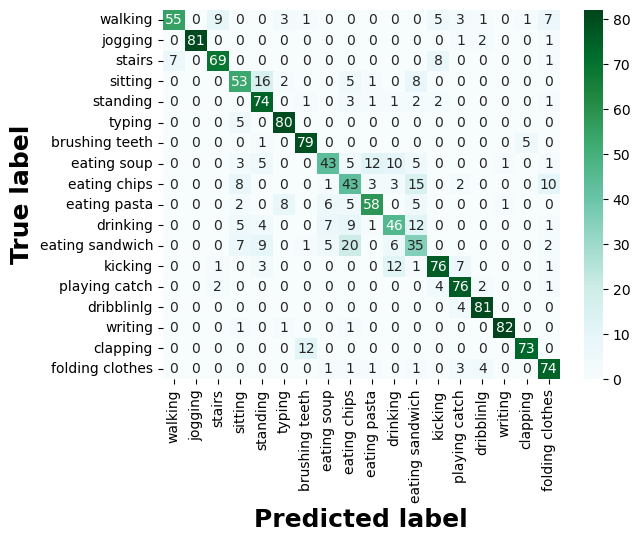

In [ ]:
import seaborn as sns
cm = confusion_matrix(y, y_predict)
df_cm = pd.DataFrame(cm, index=[i for i in activities], columns = [i for i in activities])
plt.figure()
ax = sns.heatmap(df_cm, cbar = True, cmap="BuGn", annot = True, fmt = 'd')
plt.setp(ax.get_xticklabels(), rotation = 90)
plt.ylabel('True label', fontweight = 'bold', fontsize = 18)
plt.xlabel('Predicted label', fontweight = 'bold', fontsize = 18)
plt.show()

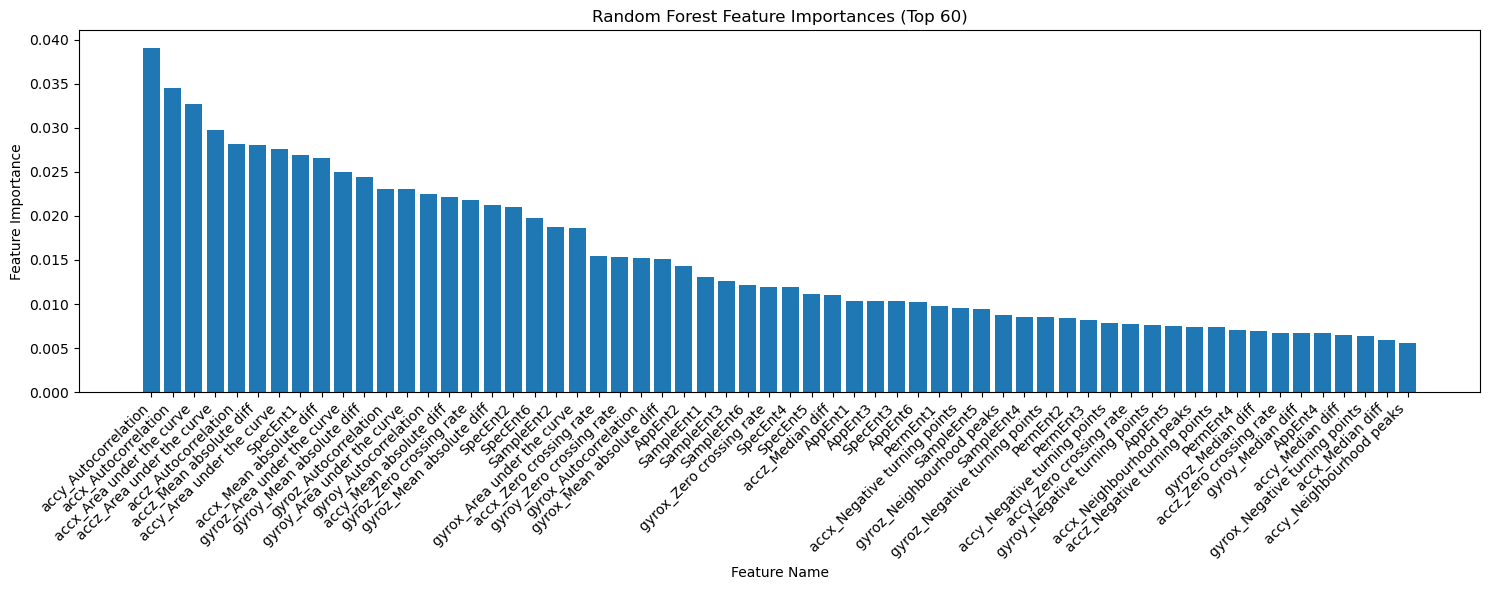

In [ ]:


feature_names = x_test_features.columns.tolist()
feature_importances = classifier.feature_importances_

# Sort indices based on feature importance
indices = np.argsort(feature_importances)[::-1]

# Plotting the feature importances with feature names
# Plotting the feature importances for the first 60 features
plt.figure(figsize=(15, 6))
plt.bar(range(60), feature_importances[indices][:60], align="center")
plt.xticks(range(60), [feature_names[i] for i in indices][:60], rotation=45, ha="right")
plt.xlabel("Feature Name")
plt.ylabel("Feature Importance")
plt.title("Random Forest Feature Importances (Top 60)")
plt.tight_layout()
plt.show()

KeyError: 'PermEnt5'

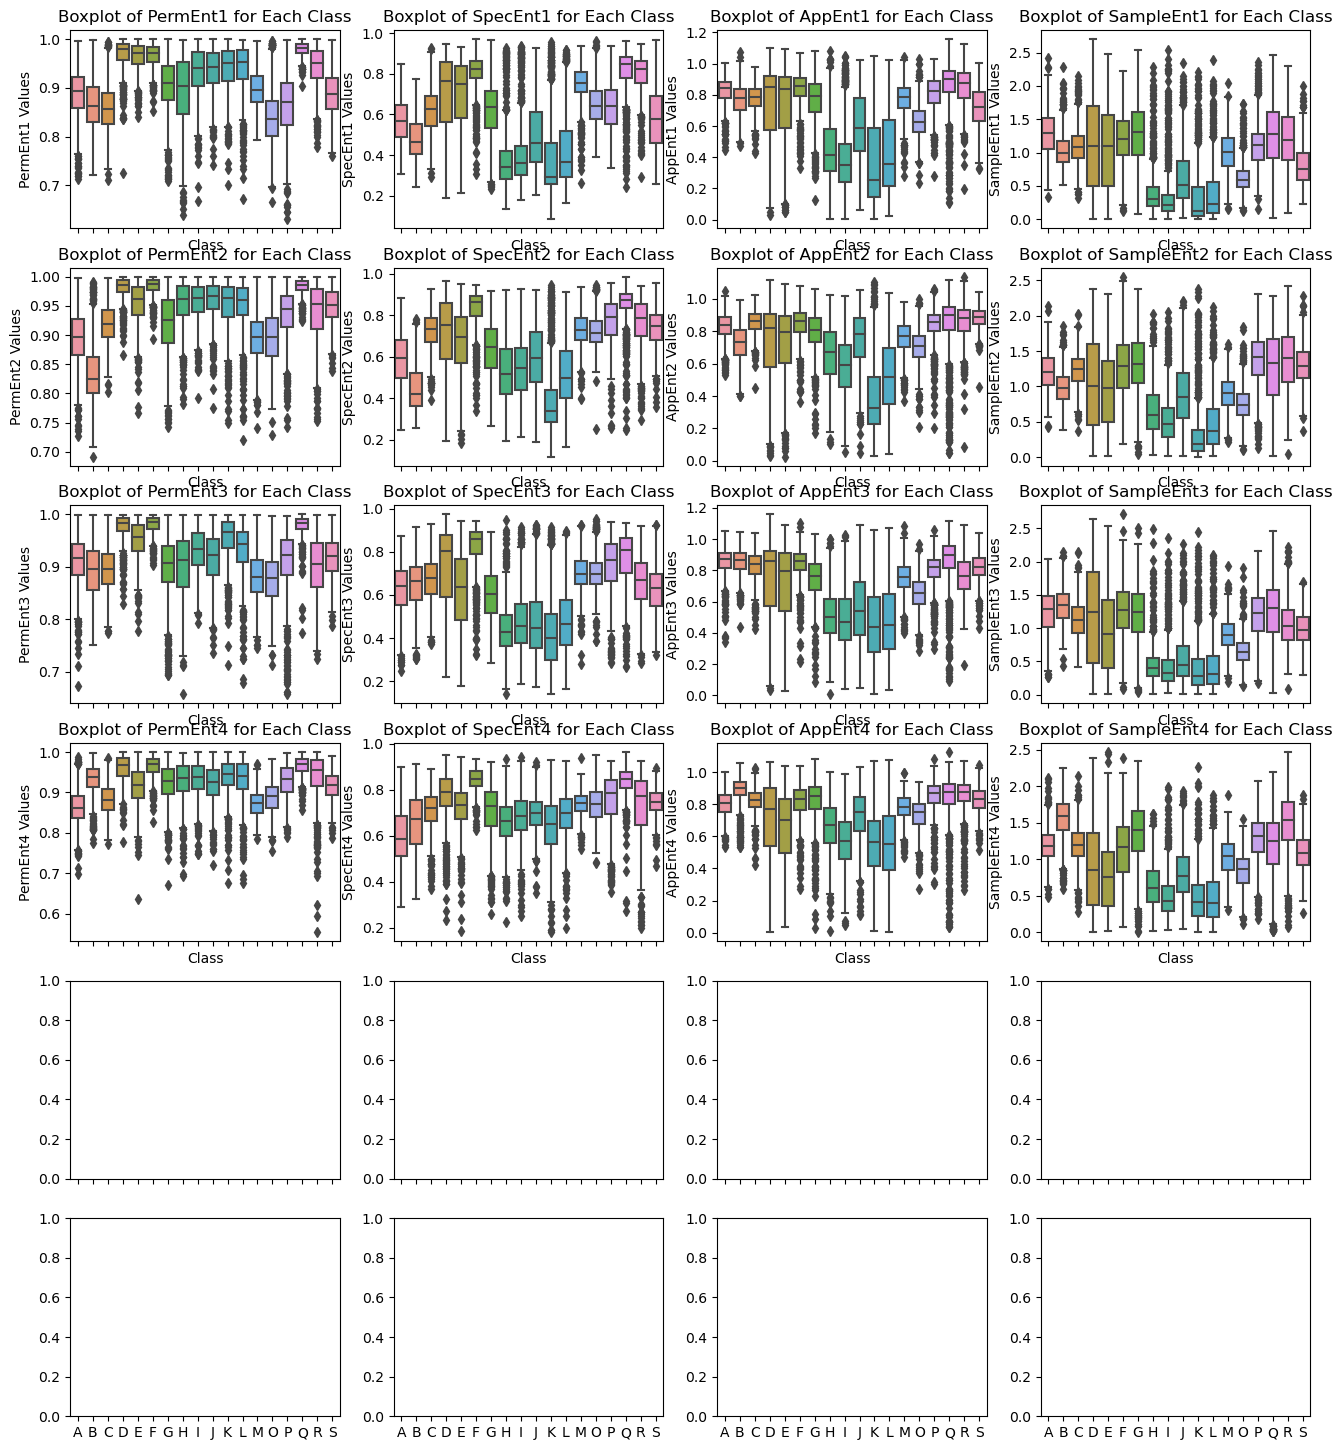

In [ ]:
feature_names = ['PermEnt', 'SpecEnt', 'AppEnt','SampleEnt']
num_rows = 6
num_columns = 4

# Create subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(16, 18), sharex=True)

# Flatten the axes array for easier iteration
axes = axes.flatten()

for i in range(1, 7):  # Iterate over components 1 to 6
    for j, feature in enumerate(feature_names):
        current_feature = f"{feature}{i}"

        # Create a boxplot for each feature in each subplot
        sns.boxplot(x=y_train, y=x_train_features[current_feature], ax=axes[(i-1) * num_columns + j])
        axes[(i-1) * num_columns + j].set_title(f'Boxplot of {current_feature} for Each Class')
        axes[(i-1) * num_columns + j].set_xlabel('Class')
        axes[(i-1) * num_columns + j].set_ylabel(f'{current_feature} Values')

# Adjust layout
plt.tight_layout()
plt.show()

